<a> <img src="Theater_banner_title.jpg" width=700 align="center"></a>

<h1 align="left"><font size="5">Capstone Project - Performing Arts Theater Hotspots in the US</font></h1>

### Table of Contents

1. Import python libraries
2. Import data and wrangle
2. 

### 1. Import libraries

In [1]:
# Import libraries
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

# !conda install -c conda-forge geopy --yes # uncomment this line if necessary
# get_ipython().system("conda install -c conda-forge geopy --yes") # uncomment this line necessary
# !pip install geopy  # this is the option that worked. Only needs to be run once
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from operator import itemgetter

# from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe -- deprecated
from pandas import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn import linear_model

In [2]:
# !conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

In [3]:
# Additional libraries to import
# !pip install geocoder
import geocoder
from IPython.display import display
import re

In [866]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 6.0) # set default size of plots

print('Libraries imported.')

Libraries imported.


#### Load a table of the largest cities (population > 100,000) in the US, with population and location

Get city, state, 2018 population (estimated), population density (2016, estimated)

In [4]:
try:
    original_df = pd.read_pickle("./US_cities_by_population.pkl")
    print('Loaded city populations from file')
except:
    url = "https://en.wikipedia.org/wiki/List_of_United_States_cities_by_population"
    original_df = pd.read_html(url)[4]
    print('Loaded city populations from wikipedia')
    original_df.to_pickle("./US_cities_by_population.pkl")  # only need to save this once
    print("Saved population list for future reference")

print(f"Generated list of {original_df.shape[0]} cities")

Loaded city populations from file
Generated list of 314 cities


#### Generate a cleaned up list of cities. Go down to populations of 100,000 (consider 250,000). 

Keep city, state, population, 2010-2018 percent growth, pop_density per sq mi.  
Remove bracketed expressions, percent mark, "/sq mi"    
Rename columns

In [423]:
df = original_df[['City', 'State[c]', '2018estimate', 'Change', '2016 population density']].copy()  # create a deep copy
df.columns    = ['City', 'State', 'Population', 'Growth', 'Density']
df["City"]    = df.City.replace({"\[.*\]":""}, regex=True)
df["City"]    = df["City"].replace({"\[.*\]":""}, regex=True)
df["City"]    = df["City"].replace('[–]',' ', regex=True)  # change "Winston-Salem" to "Winston Salem"
df["Growth"]  = df["Growth"].replace({"%$":""}, regex=True)
df["Growth"]  = df["Growth"].replace({"^\+":""}, regex=True)
df["Density"] = df["Density"].replace({"/sq\smi$":""}, regex=True)
df["Density"] = df["Density"].replace({",":""}, regex=True)
df.tail(10)

,City,State,Population,Growth,Density
304,Davenport,Iowa,102085,2.41,1631
305,South Bend,Indiana,101860,0.68,2457
306,Vista,California,101224,7.88,5436
307,Tuscaloosa,Alabama,101113,11.77,1399
308,Clinton,Michigan,100800,4.14,3573
309,Edison,New Jersey,100693,0.73,3389
310,Woodbridge,New Jersey,100450,0.87,4351
311,San Angelo,Texas,100215,7.53,1681
312,Kenosha,Wisconsin,100164,0.95,3577
313,Vacaville,California,100154,8.36,3449


### Get the latitude and longitude for each city. Save results in US_cities_by_population_latlng

In [425]:
try:
    city_df = pd.read_pickle("./US_cities_by_population_latlng.pkl")
    print("Loaded cities with latitude and longitude from file.")
except:
    df=df.reindex(columns=[*df.columns.tolist(), 'Latitude', 'Longitude'], fill_value=None)
    for idx in df.index:
        city_state =  df["City"][idx] + ", " + df["State"][idx]
        lat_lng_coords = None

        # loop until we get the coordinates, with a max of 10 tries per postal code
        maxcount = count = 0
        while(lat_lng_coords is None):
            g = geocoder.arcgis(f'{city_state}, USA')  # use "arcgis" instead of "google"
            lat_lng_coords = g.latlng
            count += 1
            if count > 10:
                lat_lng_coords = [-999,-999]
            maxcount = max(count,maxcount)
        
        df.loc[idx,"Latitude"]  = lat_lng_coords[0]
        df.loc[idx,"Longitude"] = lat_lng_coords[1]
        if idx < 10:
            print(f'{city_state} is at {lat_lng_coords}')
        else:
            print('.',end="")  # geocoder calls are slow, so this shows there is progress
            if not (idx+1)%50: print("")
    print("\n")
    city_df = df.copy()    # create a deep copy
    city_df.to_pickle("./US_cities_by_population_latlng.pkl")  # only need to save this once
    print("Saved city list with latitudes and longitudes.")
    
city_df.head(10)

New York, New York is at [40.71455000000003, -74.00713999999994]
Los Angeles, California is at [34.05349000000007, -118.24531999999999]
Chicago, Illinois is at [41.884250000000065, -87.63244999999995]
Houston, Texas is at [29.760780000000068, -95.36951999999997]
Phoenix, Arizona is at [33.44825000000003, -112.07579999999996]
Philadelphia, Pennsylvania is at [39.95222000000007, -75.16217999999998]
San Antonio, Texas is at [29.42458000000005, -98.49460999999997]
San Diego, California is at [32.71568000000008, -117.16170999999997]
Dallas, Texas is at [32.77822000000003, -96.79511999999994]
San Jose, California is at [37.33865000000003, -121.88541999999995]
........................................
..................................................
..................................................
..................................................
..................................................
..................................................
..............

Saved city list with latit

,City,State,Population,Growth,Density,Latitude,Longitude
0,New York,New York,8398748,2.74,28317,40.71455,-74.00714
1,Los Angeles,California,3990456,5.22,8484,34.05349,-118.24532
2,Chicago,Illinois,2705994,0.39,11900,41.88425,-87.63245
3,Houston,Texas,2325502,10.72,3613,29.76078,-95.36952
4,Phoenix,Arizona,1660272,14.85,3120,33.44825,-112.07580
5,Philadelphia,Pennsylvania,1584138,3.81,11683,39.95222,-75.16218
6,San Antonio,Texas,1532233,15.43,3238,29.42458,-98.49461
7,San Diego,California,1425976,9.07,4325,32.71568,-117.16171
8,Dallas,Texas,1345047,12.29,3866,32.77822,-96.79512
9,San Jose,California,1030119,8.90,5777,37.33865,-121.88542


#### Tasks:

1) set up FourSquare access parameters  
2) For each row (city) of the city dataframe (city_df):  
    (a) search for all performing arts venues,  
    (b) then filter that list to only count the theaters.  
3) Add the theater count to a column in city_df, and a concatinated list of theater names in another column  
4) Generate a US map with dots, where the size of the dot is base on the number of theaters in that city  
5) Generate a plot of theaters vs. city population

In [7]:
# CLIENT_ID = 'your-client-ID' # your Foursquare ID
# CLIENT_SECRET = 'your-client-secret' # your Foursquare Secret
# VERSION = '20180605' # Foursquare API version
CLIENT_ID     = 'HYJIVB4VRZEEUO5SXGXZ2LVNLBQ0WTDUZXL3PEO3JKJIDBB1' # your Foursquare ID
CLIENT_SECRET = 'PYPFOFOGOGFMMOFKZ2QU0RAJ1I4WHW3CWWMBL3GMBZFRYAOP' # your Foursquare Secret
VERSION       = '20180604'

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: HYJIVB4VRZEEUO5SXGXZ2LVNLBQ0WTDUZXL3PEO3JKJIDBB1
CLIENT_SECRET:PYPFOFOGOGFMMOFKZ2QU0RAJ1I4WHW3CWWMBL3GMBZFRYAOP


In [758]:
INTENT    = 'browse'
LIMIT     = 500 # limit of number of venues returned by Foursquare API # Apparently there is a limit of 50 venues returned per call. AGGGH!
RADIUS    = 10000 # define radius, in meters (10km)  # default search covers the entire city
categoryId           = "4bf58dd8d48988d137941735" # performing arts theaters and other related venues
requiredCategoryName = 'Theater'  # if used for Europe, modify to allow the use of "Theatre"

In [759]:
# create  a test URL - using a city and state
cityState = "Columbus, Ohio"
url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&categoryId={}&intent={}&near={}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    categoryId,  
    INTENT,
    cityState, 
    RADIUS,
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/search?&client_id=HYJIVB4VRZEEUO5SXGXZ2LVNLBQ0WTDUZXL3PEO3JKJIDBB1&client_secret=PYPFOFOGOGFMMOFKZ2QU0RAJ1I4WHW3CWWMBL3GMBZFRYAOP&v=20180604&categoryId=4bf58dd8d48988d137941735&intent=browse&near=Columbus, Ohio&radius=10000&limit=500'

In [1231]:
city_df.loc[city_df["Theaters"] == 0]

,City,State,Population,Growth,Density,Latitude,Longitude,Theaters,Colleges
78,St. Petersburg,Florida,265098,8.31,4223,27.77119,-82.63876,0,2
89,North Las Vegas,Nevada,245949,13.36,2436,36.20071,-115.12225,0,0
91,Chesapeake,Virginia,242634,9.19,703,36.71428,-76.24779,0,0
117,Aurora,Illinois,199602,0.86,4479,41.75710,-88.31613,0,0
123,Port St. Lucie,Florida,195248,18.62,1557,27.27481,-80.36367,0,0
163,Palmdale,California,156667,2.56,1484,34.57923,-118.11657,0,0
179,Paterson,New Jersey,145627,-0.39,17500,40.91661,-74.17164,0,0
188,Miramar,Florida,140823,15.39,4709,25.98623,-80.30094,0,0
253,Palm Bay,Florida,114194,10.66,1676,27.99990,-80.67262,0,0
257,Miami Gardens,Florida,113069,5.51,6212,25.92753,-80.22215,0,0


In [1232]:
city_df.loc[19]

City                    Washington
State         District of Columbia
Population                  702455
Growth                       16.74
Density                      11148
Latitude                   38.8904
Longitude                  -77.032
Theaters                        47
Colleges                        10
Name: 19, dtype: object

In [1219]:
city_df["Theaters"].loc[63] = 86
city_df["Colleges"].loc[63] = 11
city_df["Theaters"].loc[88] = 20
city_df["Colleges"].loc[78] = 2
city_df["Theaters"].loc[78] = 21



/Users/John/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [1228]:
with open('./US_theater_venues.txt', 'w') as file:
    json.dump(venues_list, file)

In [1184]:
# create  a test URL - using a zip code - try Washington DC's zip
zipcode = "20045"
#zipcode = "10036"
zipcode = "63102"  # St. Louis
url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&categoryId={}&intent={}&near={}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    categoryId,  
    INTENT,
    zipcode, 
    RADIUS,
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/search?&client_id=HYJIVB4VRZEEUO5SXGXZ2LVNLBQ0WTDUZXL3PEO3JKJIDBB1&client_secret=PYPFOFOGOGFMMOFKZ2QU0RAJ1I4WHW3CWWMBL3GMBZFRYAOP&v=20180604&categoryId=4bf58dd8d48988d137941735&intent=browse&near=63102&radius=10000&limit=500'

In [1185]:
# Test
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e98abff9da7ee001b7aa741'},
 'response': {'venues': [{'id': '4acbc3fdf964a5201ec720e3',
    'name': 'The Fabulous Fox',
    'location': {'address': '527 N Grand Blvd',
     'crossStreet': 'Washington Ave.',
     'lat': 38.6392051370539,
     'lng': -90.23240676851181,
     'labeledLatLngs': [{'label': 'display',
       'lat': 38.6392051370539,
       'lng': -90.23240676851181}],
     'postalCode': '63103',
     'cc': 'US',
     'city': 'St Louis',
     'state': 'MO',
     'country': 'United States',
     'formattedAddress': ['527 N Grand Blvd (Washington Ave.)',
      'St Louis, MO 63103',
      'United States']},
    'categories': [{'id': '4bf58dd8d48988d137941735',
      'name': 'Theater',
      'pluralName': 'Theaters',
      'shortName': 'Theater',
      'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/performingarts_theater_',
       'suffix': '.png'},
      'primary': True}],
    'venuePage': {'id': '51694422'},
  

In [659]:
# function to get unique values in a list
def unique(list1): 
      
    # insert the list to the set 
    list_set = set(list1) 
    # convert the set to the list 
    unique_list = (list(list_set))
    
    return unique_list

In [546]:
# Define and save a dictionary that converts state names to state abbreviations and vice versa
state_abbr={
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
    'American Samoa': 'AS',
    'District of Columbia': 'DC',
    'Federated States of Micronesia': 'FM',
    'Guam': 'GU',
    'Marshall Islands': 'MH',
    'Northern Mariana Islands': 'MP',
    'Palau': 'PW',
    'Puerto Rico': 'PR',
    'Virgin Islands': 'VI'}
# Add a reverse directory
ivd = {v: k for k, v in state_abbr.items()}

state_abbr.update(ivd)

with open('./state_abbr.txt', 'w') as file:
    json.dump(state_abbr, file)

In [448]:
def combine_city_state(city,state):
  # return city_state:  <city>, <2-letter state>
    if len(state) > 2:
        try:
            state = state_abbr[state]
        except:
            with open('./state_abbr.txt', 'r') as file:
                state_abbr = json.load(file)
            state = state_abbr[state]
    
    # Define the "city, state" for the search
    city_state = f"{city}, {state}"
    return city_state

In [736]:
def getCityZipCodes(city,state):
    APIkey = 'cUFEF53I6cj2mYOySZXHKVFvwPFNRFCekd5rcd4ijL1PdGEMlkPg7wAeOdoM3Z2y'
#     https://www.zipcodeapi.com/API#locToZips
#     https://www.zipcodeapi.com/rest/<api_key>/city-zips.<format>/<city>/<state>
#     Example:
#         https://www.zipcodeapi.com/rest/cUFEF53I6cj2mYOySZXHKVFvwPFNRFCekd5rcd4ijL1PdGEMlkPg7wAeOdoM3Z2y/
#               city-zips.json/Salt Lake City/UT
#     Error Codes
#     Error codes are returned via the HTTP response code.
#     Status Code	Reason
#     400	The request format was not correct.
#     401	The API key was not found, was not activated, or has been disabled.
#     404	A zip code you provided was not found.
#     429	The usage limit for your application has been exceeded for the hour time period. (10 per hour)

    if len(state) > 2:
        try:
            state = state_abbr[state]
        except:
            with open('./state_abbr.txt', 'r') as file:
                state_abbr = json.load(file)
            state = state_abbr[state]
    city_state = f"{city}, {state}"
    
    # Load saved dictionary or create a new empty dictionary
    try:                               # city_zipcodes.txt may not be defined yet
        with open('./city_zipcodes.txt', 'r') as file:
            city_zipcodes_dict = json.load(file)
    except:
        city_zipcodes_dict = dict()   # define a new dictionary {city_state}: [zipcodes]

    # if the [city, state] is in the cities_zipcodes_df retrieve it, otherwise use url
    try:
        zipcodes = city_zipcodes_dict[city_state]
    except KeyError:  # key not found
        # retrieve the zip codes
        url = f"https://www.zipcodeapi.com/rest/{APIkey}/city-zips.json/{city}/{state}"  # 2-letter state
        response = requests.get(url)
        print(f'response status_code: {response.status_code}')
        if response.status_code == 200:
            zips = response.json()['zip_codes']
            if len(zips) == 2 and zips[0] == '12345' and zips[1] == '54321':
                print(f'Bad zip codes returned for {city}, {state}: {zips}')
                return
            elif len(zips) == 0:
                print('Warning. No zipcodes returned. URL:\n',url)
                print('Which returned:',response.json())
                return
            # print('Zip code acquisition success!')
            city_zipcodes_dict[city_state] = zips  # add zipcodes to the dictionary
            print(f'Acquired {len(zips)} zip codes for {city}, {state}')
        elif response.status_code == 400:
            print(f'Zip code API: {response.status_code} The request format was not correct.')
            return 
        elif response.status_code == 401:
            print(f'Zip code API: {response.status_code} The API key was not found, not activated, or has been disabled.')
            return 
        elif response.status_code == 404:
            print(f'Zip code API: {response.status_code} The zip code was not found (API key not found?)')
            return
        elif response.status_code == 429:
            print(f'Zip code API: {response.status_code} Zip code usage limit exceeded.')
            return 
        else:
            print(f'Zip code API: error {response.status_code}')
            return
        zipcodes = city_zipcodes_dict[city_state]
        if len(zipcodes):
            # save updated cities_zipcodes_dict
            with open('./city_zipcodes.txt', 'w') as file:
                json.dump(city_zipcodes_dict, file)
            print(f"Updated city_zipcodes - added {city}, {state}.")

    return zipcodes    

In [322]:
# Clean up zip code file. Delete entries if they contain "12345" and "54321"
# This is necessary because, after repeated calls to get zip codes, the API starts to return 12345 and 54321 as a means of avoiding abuse

with open('./city_zipcodes.txt', 'r') as file:
    city_zipcodes_dict = json.load(file)

for key in list(city_zipcodes_dict):
    value = city_zipcodes_dict[key]
    if len(value) == 2 and value[0] == '12345' and value[1] == '54321':
        print(f'found a bad one: {key}')
        del city_zipcodes_dict[key]
    
with open('./city_zipcodes.txt', 'w') as file:
    json.dump(city_zipcodes_dict, file)

In [812]:
def getTheatersByZip(city,state):
    # get all zip codes in city, state (use 2-letter state abbreviation for state)
    # get foursquare venues for each zip code
    # Note that some returned venues may be in neighboring cities
    
    # get zip codes for this city/state, if possible
    zipcodes = getCityZipCodes(city,state)
    
    city_state = combine_city_state(city, state)
    print(f'Searching {len(zipcodes)} zip codes for venues in {city_state}.')
    
    results_full = []
    # for zipcode in city_zipcodes_dict[city_state]:
    for zipcode in zipcodes:
        # create the API request URL
        # url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&categoryId={}&intent={}&near={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            categoryId,  
            INTENT,
            zipcode, 
            RADIUS,
            LIMIT)
        # print(url)
        # make the GET request
        try:
            response = requests.get(url).json()
            results = response['response']['venues']
            results_full.append(results)
        except:
            # print(f'Note: no valid venues were returned for {city_state}, zip code {zipcode}')
            pass
    
    results_full = [item for sublist in results_full for item in sublist]  # flatten a list of a list into a single flattened list
    return results_full

In [687]:
def list_contains(list_of_lists,item1, item2):
    found = False
    for sublist in list_of_lists:
        try:
            if sublist[0] == item1 and sublist[1] == item2:
                found = True
                return found
        except:
            print('Warning. No city or state found in ',sublist)
    
    return found

In [729]:
# Test zip code retrieval
APIkey = 'cUFEF53I6cj2mYOySZXHKVFvwPFNRFCekd5rcd4ijL1PdGEMlkPg7wAeOdoM3Z2y'
city = 'Denton'
state = 'TX'
url = f"https://www.zipcodeapi.com/rest/{APIkey}/city-zips.json/{city}/{state}"
response = requests.get(url)
print(f'response status_code: {response.status_code}')
response.json()

response status_code: 200


{'zip_codes': ['76201',
  '76202',
  '76203',
  '76204',
  '76205',
  '76206',
  '76207',
  '76208',
  '76209',
  '76210']}

In [735]:
# Test getCityZipCodes
city = 'Denton'
state = 'TX'
zipcodes = getCityZipCodes(city,state)

response status_code: 200
Acquired 10 zip codes for Denton, TX
Updated city_zipcodes - added Denton, TX.


In [846]:
def getNearbyTheaters(cities, states):
    # Find all Performing Arts Venues with a category name of "Theater" in the requested (cities, states)
    try:
        with open('./US_theater_venues.txt', 'r') as file:
            venues_list = json.load(file)
    except:
        venues_list=[]
        
    count = 0
    for city, state in zip(cities, states):
        print(f'Processing {city}, {state}')
        # If this city, state are already completed, skip to the next city
        if len(venues_list) and list_contains(venues_list,city,state): 
            continue
        
        try:
            state2 = state_abbr[state]  # state abbreviation
        except:
            print(f'Loading state abbreviation file for {state}')
            with open('./state_abbr.txt', 'r') as file:
                state_abbr = json.load(file)
            state2 = state_abbr[state]
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&categoryId={}&intent={}&near={}, {}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            categoryId,  
            INTENT,
            city,
            state, 
            LIMIT)
        # make the GET request
        try:
            response = requests.get(url).json()
            results = response['response']['venues']
        except:
            print('Error. Did not get a successful response with venues for this foursquare API get:')
            print('Here is the URL:\n',url)
            print('Which returned this response:\n',response)
        
        # Extract all of the "name" keys values from results, a list of dictionaries
        name_list = list(map(itemgetter('name'),results))
        
        if len(name_list) == 50:  # search returned the maximum number of venues, which is likely incomplete, so search by zip code
            print(f'      [Found 50 venues for {city}, {state2}, so repeating search using zip codes.]')
            results = getTheatersByZip(city,state2)
        
        name_list = []   # empty out name_list, then build it up
        # slow, but loop through each venue
        for venue in results:  # append "good" venues to the list - that match the city, state, and type (name) of venue = Theater
            try:
                if venue['location']['city'] != city.replace('.',''):    continue  # remove any "." in city, like St. Louis
                if venue['location']['state'].replace('.','') != state2:  continue  # remove any "." in state, like "D.C."
                category_list = venue['categories']
                categoryname_list = [d['name'] for d in category_list if 'name' in d]
                drop = True
                for name in categoryname_list: 
                    if name == requiredCategoryName: drop = False  # at least one category name must match
                if drop: continue
                # Found a "good" venue. Add the venue name to the name list
                name_list.append(venue['name'])
            except:
                pass
    
        # remove any redundant venue names from the list
        name_list = unique(name_list)
        
        # return only relevant information for each venue
        venues_list.append([
            city, 
            state,
            len(name_list),
            name_list])
        print(f'Found {len(name_list)} performing arts theaters in {city}, {state}.')
        
        # Save/Update current results
        with open('./US_theater_venues.txt', 'w') as file:
            json.dump(venues_list, file)
            
        count += 1
        if count >= 1:   # Limit to a few locations for initial testing
            break
    
    return venues_list

In [1226]:
# Update venues_list for a single city, state - edit city match criteria below as needed
# cities = ["St. Louis"]
# states = ["Missouri"]
# cities = ["Winston Salem"]
# states = ["North Carolina"]
# cities = ["St. Petersburg"]
# states = ["Florida"]
cities = ["North Las Vegas"]
states = ["Nevada"]

# Find all Performing Arts Venues with a category name of "Theater" in the requested (cities, states)
try:
    with open('./US_theater_venues.txt', 'r') as file:
        venues_list = json.load(file)
except:
    venues_list=[]
        

for city, state in zip(cities, states):
    print(f'Processing {city}, {state}')
        
    try:
        state2 = state_abbr[state]  # state abbreviation
    except:
        print(f'Loading state abbreviation file for {state}')
        with open('./state_abbr.txt', 'r') as file:
            state_abbr = json.load(file)
        state2 = state_abbr[state]
            
    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&categoryId={}&intent={}&near={}, {}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        categoryId,  
        INTENT,
        city,
        state, 
        LIMIT)
    # make the GET request
    try:
        response = requests.get(url).json()
        results = response['response']['venues']
    except:
        print('Error. Did not get a successful response with venues for this foursquare API get:')
        print('Here is the URL:\n',url)
        print('Which returned this response:\n',response)
    
    # Extract all of the "name" keys values from results, a list of dictionaries
    name_list = list(map(itemgetter('name'),results))
    
    if len(name_list) == 50:  # search returned the maximum number of venues, which is likely incomplete, so search by zip code
        print(f'      [Found 50 venues for {city}, {state2}, so repeating search using zip codes.]')
        results = getTheatersByZip(city,state2)
        
    name_list = []   # empty out name_list, then build it up
    # slow, but loop through each venue
    for venue in results:  # append "good" venues to the list - that match the city, state, and type (name) of venue = Theater
        try:
            # if venue['location']['city'] != city.replace('.',''):    continue  # remove any "." in city, like St. Louis
            if venue['location']['city'].replace('-','') != city.replace('-',''):    continue  # remove any "-" in city, like Winston-Salem
            if venue['location']['state'].replace('.','') != state2:  continue  # remove any "." in state, like "D.C."
            category_list = venue['categories']
            categoryname_list = [d['name'] for d in category_list if 'name' in d]
            drop = True
            for name in categoryname_list: 
                if name == requiredCategoryName: drop = False  # at least one category name must match
            if drop: continue
            # Found a "good" venue. Add the venue name to the name list
            name_list.append(venue['name'])
        except:
            pass
    
    # remove any redundant venue names from the list
    name_list = unique(name_list)
    
    print(f'Found {len(name_list)} performing arts theaters in {city}, {state}.')
    # Insert results into the proper row in venues_list
#     venues_list.loc[]
#     append([
#         city, 
#         state,
#         len(name_list),
#         name_list])
        
# Save/Update current results
# with open('./US_theater_venues.txt', 'w') as file:
#     json.dump(venues_list, file)

Processing Miami Gardens, Florida
Found 0 performing arts theaters in Miami Gardens, Florida.


In [1227]:
results

[]

In [791]:
# Get zip codes for all city, state areas. Note that after many acquistions, bad zip code data will be 
# returned, so this may need to be run on multiple days. 
cities = city_df['City']
states = city_df['State']

print('Number of zipcodes in or near each city:')
for city, state in zip(cities, states):
    zipcodes = getCityZipCodes(city,state)
    if zipcodes == None:
        break
    else:
        print(f'{len(zipcodes):3} in {city}, {state}')
        if len(zipcodes) < 1: break

Number of zipcodes in or near each city:
165 in New York, New York
102 in Los Angeles, California
 94 in Chicago, Illinois
190 in Houston, Texas
 82 in Phoenix, Arizona
 87 in Philadelphia, Pennsylvania
 89 in San Antonio, Texas
 85 in San Diego, California
121 in Dallas, Texas
 58 in San Jose, California
 81 in Austin, Texas
 57 in Jacksonville, Florida
 60 in Fort Worth, Texas
 47 in Columbus, Ohio
 66 in San Francisco, California
 74 in Charlotte, North Carolina
 62 in Indianapolis, Indiana
 65 in Seattle, Washington
 80 in Denver, Colorado
279 in Washington, District of Columbia
 55 in Boston, Massachusetts
140 in El Paso, Texas
 57 in Detroit, Michigan
 44 in Nashville, Tennessee
 64 in Portland, Oregon
 68 in Memphis, Tennessee
 79 in Oklahoma City, Oklahoma
 81 in Las Vegas, Nevada
 66 in Louisville, Kentucky
 68 in Baltimore, Maryland
 43 in Milwaukee, Wisconsin
 47 in Albuquerque, New Mexico
 56 in Tucson, Arizona
 60 in Fresno, California
 19 in Mesa, Arizona
103 in Sacrament

In [ ]:
# save current version of venues_list
# with open('./US_theater_venues.txt', 'w') as file:
#    json.dump(venues_list, file)

### Gather performing arts venue information for each US city the a large population. Save the results in this file: US_theater_venues.txt 

In [848]:
venues_list = getNearbyTheaters(cities = city_df['City'],
                                states = city_df['State']
                                )
with open('./US_theater_venues.txt', 'w') as file:
    json.dump(venues_list, file)

Processing New York, New York
Loading state abbreviation file for New York
      [Found 50 venues for New York, NY, so repeating search using zip codes.]
Searching 165 zip codes for venues in New York, NY.
Found 78 performing arts theaters in New York, New York.


In [1230]:
# LOAD the US theater venues list
with open('./US_theater_venues.txt', 'r') as file:
    venues_list = json.load(file)

In [890]:
# ADD THE NUMBER OF VENUES TO city_df and save this dataframe
# city_df['Theaters'] = np.array(venues_list)[:,2]
# city_df.to_pickle("./US_cities_by_population_latlng.pkl")  # only need to save this once
# print("Saved city list with the number of theaters.")

In [1027]:
# Scrub city_df and convert numeric columns to type float
# city_df = pd.read_pickle("./US_cities_by_population_latlng.pkl")
# city_df['Growth'] = city_df['Growth'].str.replace('−','-')
# city_df['Growth'] = city_df['Growth'].str.replace('\[ab\]','7.8')  # replace with median value
# city_df['Growth'] = city_df['Growth'].astype('float')
# city_df[['Population','Theaters']] = city_df[['Population','Theaters']].astype('int')
# city_df['Density'] = city_df['Density'].astype('int')
# city_df.to_pickle("./US_cities_by_population_latlng.pkl")  # save updated, scrubbed city_df

In [1255]:
city_df.head(30)

,City,State,Population,Growth,Density,Latitude,Longitude,Theaters,Colleges
0,New York,New York,8398748,2.74,28317,40.71455,-74.00714,78,30
1,Los Angeles,California,3990456,5.22,8484,34.05349,-118.24532,163,20
2,Chicago,Illinois,2705994,0.39,11900,41.88425,-87.63245,169,17
3,Houston,Texas,2325502,10.72,3613,29.76078,-95.36952,106,12
4,Phoenix,Arizona,1660272,14.85,3120,33.44825,-112.07580,65,6
5,Philadelphia,Pennsylvania,1584138,3.81,11683,39.95222,-75.16218,79,16
6,San Antonio,Texas,1532233,15.43,3238,29.42458,-98.49461,79,7
7,San Diego,California,1425976,9.07,4325,32.71568,-117.16171,84,11
8,Dallas,Texas,1345047,12.29,3866,32.77822,-96.79512,57,7
9,San Jose,California,1030119,8.90,5777,37.33865,-121.88542,40,5


In [1028]:
city_df.describe()

,Population,Growth,Density,Latitude,Longitude,Theaters
count,3.140000e+02,314.000000,314.000000,314.000000,314.000000,314.000000
mean,3.023532e+05,9.015828,4189.464968,36.421485,-98.858748,15.232484
std,5.865428e+05,9.326341,3308.500106,5.237898,17.153901,22.380962
min,1.001540e+05,-5.760000,175.000000,21.304930,-157.857880,0.000000
25%,1.205110e+05,2.785000,2299.750000,33.199810,-117.373735,3.000000
50%,1.661260e+05,7.840000,3445.500000,36.013600,-96.719290,7.500000
75%,2.642332e+05,12.152500,4766.750000,40.434700,-83.559215,16.000000
max,8.398748e+06,67.590000,28317.000000,61.217530,-71.056740,169.000000


### Download the list of colleges with performing arts departments

In [1069]:
# download the list of colleges with performing arts departments
# url = "http://www.univsearch.com/family-search.php?family=50"
# colleges_df = pd.read_html(url)[1]
# colleges_df.head(10)


# # Create a dictionary with city_state and number of colleges in each
# city_college_dict = {}
# for index, row in colleges_df.iterrows():
#     city_state = f"{row['CITY']}, {row['STATE']}"
#     count = city_college_dict.get(city_state,0)
#     count += 1
#     city_college_dict[city_state] = count
    

# # Try some test cases
# city_state = 'New York, NY'
# print(f'{city_state:12} has {city_college_dict.get(city_state.upper(),0)} colleges')
# city_state = 'Boston, MA'
# print(f'{city_state:12} has {city_college_dict.get(city_state.upper(),0)} colleges')


# # Retrieve the number of colleges in each city and add this to the city_df dataframe
# college_count = []
# for index, row in city_df.iterrows():
#     city_state = f"{row['City']}, {state_abbr[row['State']]}"
#     college_count.append(city_college_dict.get(city_state.upper(),0))

# city_df['Colleges'] = college_count
# city_df.to_pickle("./US_cities_by_population_latlng.pkl")  # save updated dataframe with colleges

In [1207]:
city_college_dict[]

{'CAGUAS, PR': 1,
 'ABILENE, TX': 2,
 'PONCE, PR': 2,
 'MINNEAPOLIS, MN': 7,
 'SAN FRANCISCO, CA': 9,
 'PHILADELPHIA, PA': 16,
 'ALAMOSA, CO': 1,
 'GARDEN CITY, NY': 2,
 'ADRIAN, MI': 2,
 'HACKENSACK, NJ': 1,
 'SAN DIEGO, CA': 11,
 'ATLANTA/DECATUR, GA': 1,
 'GREELEY, CO': 2,
 'TEMPE, AZ': 4,
 'NORMAL, AL': 1,
 'MONTGOMERY, AL': 4,
 'GRAHAM, NC': 1,
 'ALBANY, GA': 1,
 'CALDWELL, ID': 1,
 'NEW HAVEN, CT': 3,
 'ALBION, MI': 1,
 'READING, PA': 1,
 'PHILIPPI, WV': 1,
 'ALEXANDRIA, MN': 1,
 'ALFRED, NY': 3,
 'SANTA MARIA, CA': 1,
 'MEADVILLE, PA': 1,
 'IOLA, KS': 1,
 'COLUMBIA, SC': 5,
 'ALMA, MI': 1,
 'ALPENA, MI': 1,
 'ALTOONA, PA': 1,
 'MILWAUKEE, WI': 8,
 'ALVIN, TX': 1,
 'AMARILLO, TX': 1,
 'CHICAGO, IL': 17,
 'NEW YORK, NY': 30,
 'HOLLYWOOD, CA': 2,
 'LOS ANGELES, CA': 20,
 'ATLANTA, GA': 14,
 'SACRAMENTO, CA': 5,
 'WASHINGTON, DC': 10,
 'AMHERST, MA': 3,
 'DONALDSON, IN': 1,
 'ANDERSON, SC': 1,
 'ANDERSON, IN': 1,
 'CUTHBERT, GA': 1,
 'BERRIEN SPRINGS, MI': 1,
 'LUFKIN, TX': 1,
 'SAN

In [1233]:
city_df

,City,State,Population,Growth,Density,Latitude,Longitude,Theaters,Colleges
0,New York,New York,8398748,2.74,28317,40.71455,-74.00714,78,30
1,Los Angeles,California,3990456,5.22,8484,34.05349,-118.24532,163,20
2,Chicago,Illinois,2705994,0.39,11900,41.88425,-87.63245,169,17
3,Houston,Texas,2325502,10.72,3613,29.76078,-95.36952,106,12
4,Phoenix,Arizona,1660272,14.85,3120,33.44825,-112.07580,65,6
5,Philadelphia,Pennsylvania,1584138,3.81,11683,39.95222,-75.16218,79,16
6,San Antonio,Texas,1532233,15.43,3238,29.42458,-98.49461,79,7
7,San Diego,California,1425976,9.07,4325,32.71568,-117.16171,84,11
8,Dallas,Texas,1345047,12.29,3866,32.77822,-96.79512,57,7
9,San Jose,California,1030119,8.90,5777,37.33865,-121.88542,40,5


In [916]:
tmp_df.dtypes

City           object
State          object
Population      int64
Growth        float64
Density       float64
Latitude      float64
Longitude     float64
Theaters      float64
dtype: object

In [894]:
city_df.tail(10)

,City,State,Population,Growth,Density,Latitude,Longitude,Theaters
304,Davenport,Iowa,102085,2.41,1631,41.53826,-90.57602,9
305,South Bend,Indiana,101860,0.68,2457,41.67907,-86.25405,10
306,Vista,California,101224,7.88,5436,33.20239,-117.23505,10
307,Tuscaloosa,Alabama,101113,11.77,1399,33.21042,-87.56625,9
308,Clinton,Michigan,100800,4.14,3573,42.07273,-83.97033,0
309,Edison,New Jersey,100693,0.73,3389,40.53055,-74.38114,3
310,Woodbridge,New Jersey,100450,0.87,4351,40.55452,-74.27851,1
311,San Angelo,Texas,100215,7.53,1681,31.46150,-100.44242,4
312,Kenosha,Wisconsin,100164,0.95,3577,42.58808,-87.82326,7
313,Vacaville,California,100154,8.36,3449,38.35218,-121.99263,3


Text(0, 0.5, 'Number of Theaters')

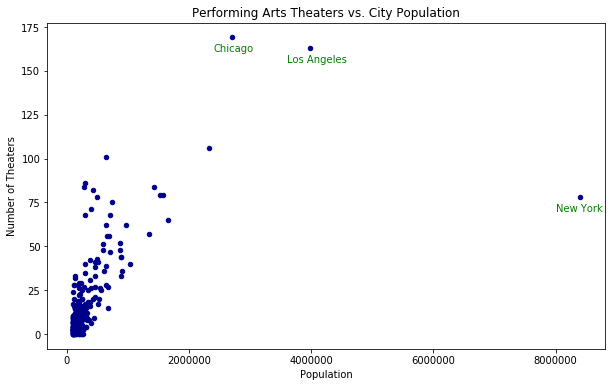

In [1240]:
ax1 = city_df[0:].plot.scatter(x='Population',
                      y='Theaters',
                      c='DarkBlue')
plt.text(8000000,70,'New York',c='Green')
plt.text(3600000,155,'Los Angeles',c='Green')
plt.text(2400000,161,'Chicago',c='Green')
plt.title('Performing Arts Theaters vs. City Population')
plt.ylabel('Number of Theaters')

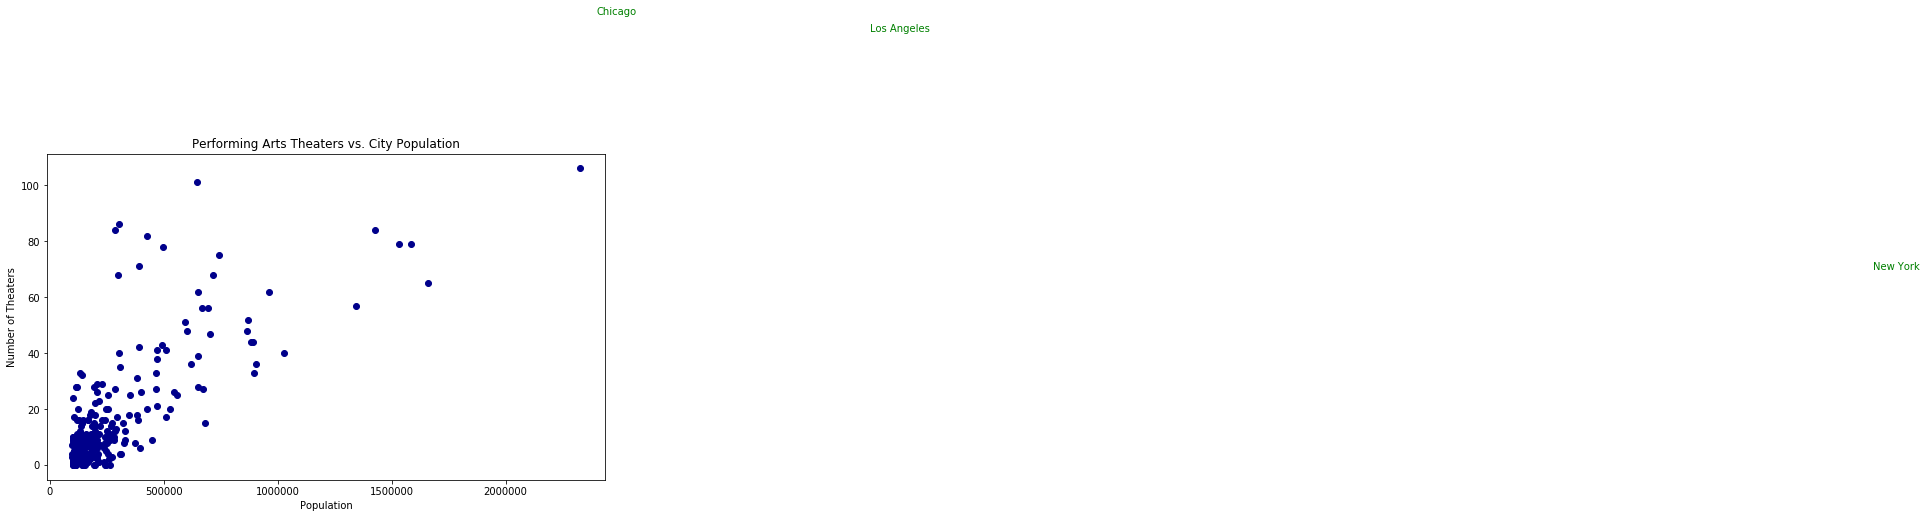

In [1238]:
fig = plt.figure()
#plt.xscale('log')
# plt.yscale('log')
plt.title('Performing Arts Theaters vs. City Population')

plt.xlabel('Population')
# plt.xlim(50000, 2500000)
plt.ylabel('Number of Theaters')
plt.scatter(city_df[3:]['Population'], city_df[3:]['Theaters'],c='DarkBlue')
# plt.text(8000000,70,'New York',c='Green')
# plt.text(3600000,155,'Los Angeles',c='Green')
# plt.text(2400000,161,'Chicago',c='Green')
fig.savefig('Theaters_vs_Population.png', dpi=fig.dpi)

In [1126]:
y = city_df['Theaters']
X = city_df[['Population','Growth','Density','Colleges']]

In [1127]:
# define the regresion model as in instance of the LinearRegression class
linear_regression = LinearRegression()
linear_regression.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [1242]:
# define the regresion model as in instance of the LinearRegression class
regr = linear_model.LinearRegression()
X = np.asanyarray(city_df[['Population','Growth','Density','Colleges']])
y = np.asanyarray(city_df['Theaters'])
regr.fit(X, y)
# The coefficients
print ('Coefficients: ', regr.coef_)

Coefficients:  [ 1.94372729e-06  1.16037640e-01 -5.05186000e-04  5.39760571e+00]


#### Prediction

In [1243]:
y_hat= regr.predict(X)

print("Residual sum of squares: %.2f"
      % np.mean((y_hat - y) ** 2))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(X, y))

Residual sum of squares: 166.32
Variance score: 0.68


#### Remove outliers (very large cities)

In [1244]:
train = city_df[3:]
y = train['Theaters']
X = train[['Population','Growth','Density','Colleges']]
regr.fit(X, y)
# The coefficients
print('Coefficients: ', regr.coef_)
print('Intercept: ',regr.intercept_)
y_hat= regr.predict(X)
print("Residual sum of squares: %.2f"
      % np.mean((y_hat - y) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance (R^2) score: %.3f' % regr.score(X, y))

Coefficients:  [ 2.88726304e-05  7.22555803e-02 -2.74520707e-05  3.82547662e+00]
Intercept:  -1.7309317967784015
Residual sum of squares: 85.53
Variance (R^2) score: 0.764


In [1245]:
y = train['Theaters']
X = train[['Population','Colleges']]
regr.fit(X, y)
# The coefficients
print ('Coefficients: ', regr.coef_)
print('Intercept: ',regr.intercept_)
y_hat= regr.predict(X)
print("Residual sum of squares: %.2f"
      % np.mean((y_hat - y) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance (R^2) score: %.3f' % regr.score(X, y))

Coefficients:  [2.93345312e-05 3.77272408e+00]
Intercept:  -1.190714395904516
Residual sum of squares: 86.00
Variance (R^2) score: 0.762


In [1250]:
y = train['Theaters']
X = train[['Population']]
X = train[['Growth']]
X = train[['Density']]
X = train[['Colleges']]
regr.fit(X, y)
# The coefficients
print ('Coefficients: ', regr.coef_)
y_hat= regr.predict(X)
print("Residual sum of squares: %.2f"
      % np.mean((y_hat - y) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance (R^2) score: %.3f' % regr.score(X, y))

Coefficients:  [5.62919386]
Residual sum of squares: 120.95
Variance (R^2) score: 0.666


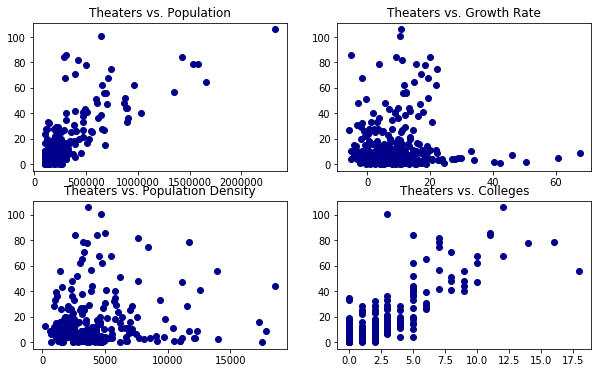

In [1241]:
fig, axs = plt.subplots(2, 2)
plt.title('Performing Arts Theaters vs. City Population')

# plt.xlabel('Population')
# plt.xlim(50000, 2500000)
# plt.ylabel('Number of Theaters')
# plt.scatter(city_df[3:]['Population'], city_df[3:]['Theaters'],c='DarkBlue')

axs[0, 0].scatter(city_df[3:]['Population'], city_df[3:]['Theaters'],c='DarkBlue')
axs[0, 0].set_title('Theaters vs. Population')
axs[0, 1].scatter(city_df[3:]['Growth'], city_df[3:]['Theaters'],c='DarkBlue')
axs[0, 1].set_title('Theaters vs. Growth Rate')
axs[1, 0].scatter(city_df[3:]['Density'], city_df[3:]['Theaters'],c='DarkBlue')
axs[1, 0].set_title('Theaters vs. Population Density')
axs[1, 1].scatter(city_df[3:]['Colleges'], city_df[3:]['Theaters'],c='DarkBlue')
axs[1, 1].set_title('Theaters vs. Colleges')

for ax in axs.flat:
    ax.set(xlabel='', ylabel='')

# Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

In [1251]:
y = train['Theaters']
X = train[['Population','Colleges']]
regr.fit(X, y)
# The coefficients
print ('Coefficients: ', regr.coef_)
print('Intercept: ',regr.intercept_)
y_hat= regr.predict(X)
print("Residual sum of squares: %.2f"
      % np.mean((y_hat - y) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance (R^2) score: %.3f' % regr.score(X, y))

Coefficients:  [2.93345312e-05 3.77272408e+00]
Intercept:  -1.190714395904516
Residual sum of squares: 86.00
Variance (R^2) score: 0.762


In [1252]:
idx = range(3,314)

/Users/John/opt/anaconda3/lib/python3.7/site-packages/matplotlib/collections.py:960: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "


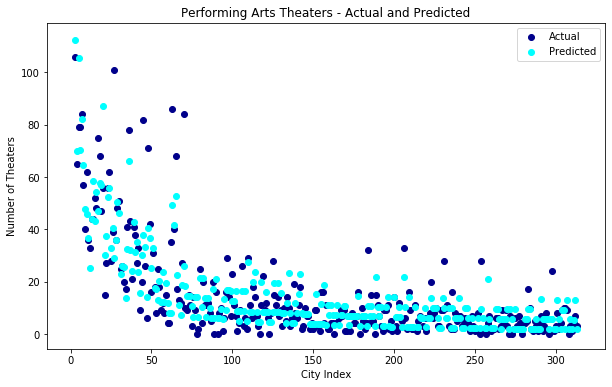

In [1253]:
fig = plt.figure()
plt.title('Performing Arts Theaters - Actual and Predicted')

plt.xlabel('City Index')
# plt.xlim(50000, 2500000)
plt.ylabel('Number of Theaters')
scatter = plt.scatter(idx, y,c='DarkBlue',label='Actual')
plt.scatter(idx, y_hat, c='Cyan',label='Predicted')
#ax.legend()

classes = ['Actual', 'Predicted']

plt.legend(handles=scatter.legend_elements()[0], labels=classes)

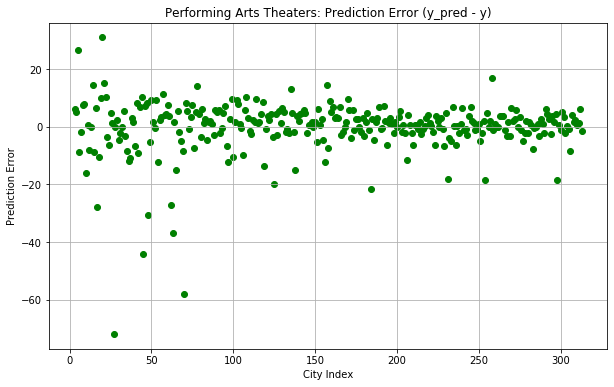

In [1254]:
fig = plt.figure()
plt.title('Performing Arts Theaters: Prediction Error (y_pred - y)')

plt.xlabel('City Index')
# plt.xlim(50000, 2500000)
plt.ylabel('Prediction Error')
scatter = plt.scatter(idx, y_hat - y,c='Green',label='Actual')
plt.grid()

In [1256]:
X = city_df[['Population','Colleges']]
y = city_df['Theaters']
y_hat= regr.predict(X)

In [1259]:
city_df['Pred_Theaters'] = y_hat
city_df['Pred_error'] = city_df['Pred_Theaters'] - city_df['Theaters']
city_df.head()

,City,State,Population,Growth,Density,Latitude,Longitude,Theaters,Colleges,Pred_Theaters,Pred_error
0,New York,New York,8398748,2.74,28317,40.71455,-74.00714,78,30,358.364343,280.364343
1,Los Angeles,California,3990456,5.22,8484,34.05349,-118.24532,163,20,191.321923,28.321923
2,Chicago,Illinois,2705994,0.39,11900,41.88425,-87.63245,169,17,142.324660,-26.675340
3,Houston,Texas,2325502,10.72,3613,29.76078,-95.36952,106,12,112.299485,6.299485
4,Phoenix,Arizona,1660272,14.85,3120,33.44825,-112.07580,65,6,70.148931,5.148931


In [1261]:
sorted_city_df = city_df.sort_values(by=['Pred_error'])

In [1271]:
sorted_city_df[['City','State','Colleges','Theaters','Pred_Theaters','Pred_error']].head(10)

,City,State,Colleges,Theaters,Pred_Theaters,Pred_error
27,Las Vegas,Nevada,3,101,29.037787,-71.962213
70,Orlando,Florida,5,84,26.054163,-57.945837
45,Minneapolis,Minnesota,7,82,37.697352,-44.302648
63,St. Louis,Missouri,11,86,49.192861,-36.807139
48,Tampa,Florida,8,71,40.516322,-30.483678
17,Seattle,Washington,7,75,47.071260,-27.928740
62,Saint Paul,Minnesota,0,35,7.835374,-27.164626
2,Chicago,Illinois,17,169,142.324660,-26.675340
184,Syracuse,New York,2,32,10.542209,-21.457791
125,Columbus,Georgia,1,28,8.277602,-19.722398


In [1270]:
sorted_city_df[['City','State','Colleges','Theaters','Pred_Theaters','Pred_error']].tail(10)

,City,State,Colleges,Theaters,Pred_Theaters,Pred_error
135,Worcester,Massachusetts,5,10,23.125521,13.125521
78,St. Petersburg,Florida,2,0,14.131259,14.131259
14,San Francisco,California,9,44,58.675140,14.675140
157,Jackson,Mississippi,4,4,18.723424,14.723424
21,El Paso,Texas,3,15,30.153233,15.153233
258,Manchester,New Hampshire,5,4,20.973774,16.973774
5,Philadelphia,Pennsylvania,16,79,105.642816,26.642816
1,Los Angeles,California,20,163,191.321923,28.321923
20,Boston,Massachusetts,18,56,87.093586,31.093586
0,New York,New York,30,78,358.364343,280.364343
